In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.models import load_model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# nltk
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# regex
import re

%matplotlib inline

2022-12-19 10:42:53.276838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 10:42:58.135211: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-19 10:43:03.617635: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-19 10:43:03.618044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Referneced bidirectional LSTM model from: 
1. https://keras.io/examples/nlp/bidirectional_lstm_imdb/
2. https://machinelearningmastery.com/develop-bidirectional-lstm-sequence-classification-python-keras/

In [79]:
train_data = pd.read_csv('final_data/train_balanced.csv')
test_data = pd.read_csv('final_data/test_balanced.csv')
# split train_data to X_train and y_train
X_train = train_data['review']
y_train = train_data['rating']
# convert y_train to one-hot encoding
y_train = to_categorical(y_train)
# split test_data to X_test and y_test
X_test = test_data['review']
y_test = test_data['rating']
# convert y_test to one-hot encoding
y_test = to_categorical(y_test)

In [80]:
# size of train and test data
print('Train data size: ', X_train.shape)
print('Test data size: ', X_test.shape)

Train data size:  (40000,)
Test data size:  (4000,)


In [81]:
# encode text into vectors
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(X_train)
# max length of a sequence
max_len = max([len(s) for s in sequences])
# pad sequences
X_train = pad_sequences(sequences, maxlen=max_len)

# tokenize test data
test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len)

In [5]:
# let tensorflow allocate memory as needed
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-12-19 10:35:48.824235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-19 10:35:49.768433: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14624 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [7]:
# define model
biLSTM_model = Sequential(
    [
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(2, activation='sigmoid')
    ]
)
biLSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
biLSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1473, 128)         1678336   
                                                                 
 bidirectional_1 (Bidirectio  (None, 1473, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,818,498
Trainable params: 1,818,498
Non-trainable params: 0
_________________________________________________________________


In [8]:
# train model
history = biLSTM_model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save model
biLSTM_model.save('models/biLSTM_model.h5')

Epoch 1/100


2022-12-19 10:45:25.700359: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600


500/500 [==============================] - 126s 206ms/step - loss: 0.1866 - accuracy: 0.9282 - val_loss: 0.0345 - val_accuracy: 0.9910
Epoch 2/100
500/500 [==============================] - 102s 203ms/step - loss: 0.0399 - accuracy: 0.9884 - val_loss: 0.0169 - val_accuracy: 0.9936
Epoch 3/100
500/500 [==============================] - 102s 203ms/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0211 - val_accuracy: 0.9949
Epoch 4/100
264/500 [==============>...............] - ETA: 42s - loss: 0.0055 - accuracy: 0.9982

Bad pipe message: %s [b'\x18\x9a\xd3\x1d\xc5:M\x13\xf3\x8e\xd9\x0eE\xb7\x8f\xfbN\x1b )\xec\xfe\xab\x8boX\xff\xb7\xf9\x00\xa8BD\xd8!\xb6\x03^n$\xe8\t\xb8h\xd7\xa5\xf5\xb2\x9a&\xf2\x00\x08\x13\x02']
Bad pipe message: %s [b'\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t1', b'.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04', b'\x03\x06', b'\x07\x08']
Bad pipe message: %s [b'\t\x08\n\x08\x0b\x08\x04']
Bad pipe message: %s [b" \x1bz;\xb19\xb7\xadj\xca\xe8\x8cO\xd1\x82+\x95\x9a\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad\xc0\xa3\xc0\x9f\xc0]\xc0a\xc0W\xc0S\xc0+\xc0/\x00\xa2\x00\x9e\xc0\xae\xc0\xac\xc0\xa2\xc0\x9e\xc0\\\xc0`\xc0V\xc0R\xc0$\xc0(\x00k\x00j\xc0#\xc0'\x00g\x00@"]
Bad pipe message: %s [b'`y\xa4\x1b\x16)\x17']
Bad pipe message: %s [b'\x08\x06\x04\x01\x05\x01\x06', b'']
Bad pipe message: %s [b"\x91\xf4e\x85,|\xb2b

500/500 [==============================] - 102s 203ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0470 - val_accuracy: 0.9895
Epoch 5/100
500/500 [==============================] - 102s 203ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.0192 - val_accuracy: 0.9942


In [82]:
# load model
biLSTM_model = load_model('models/biLSTM_model.h5')
# test the model
accr = biLSTM_model.evaluate(X_test,y_test)

125/125 [==============================] - 12s 86ms/step - loss: 0.0580 - accuracy: 0.9800


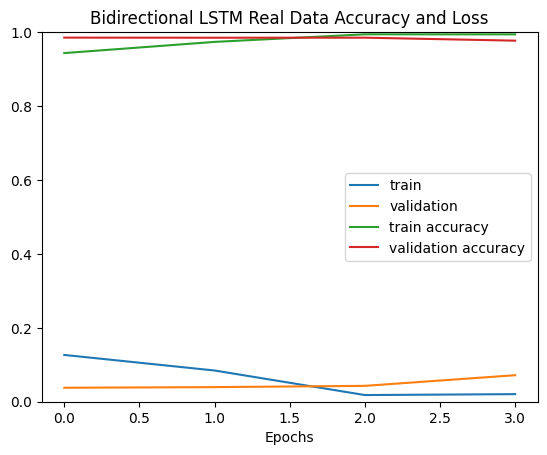

In [83]:
# plot the loss and accuracy
# x-axis: epoch
plt.xlabel('Epochs')
plt.title('Bidirectional LSTM Real Data Accuracy and Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation', 'train accuracy', 'validation accuracy'], loc='center right')
# ylim 
plt.ylim(0, 1)
# save the plot
plt.savefig('plots/biLSTM_real_data_acc_loss.png')
plt.show()

In [84]:
# y_pred
y_pred = biLSTM_model.predict(X_test)

125/125 [==============================] - 12s 84ms/step


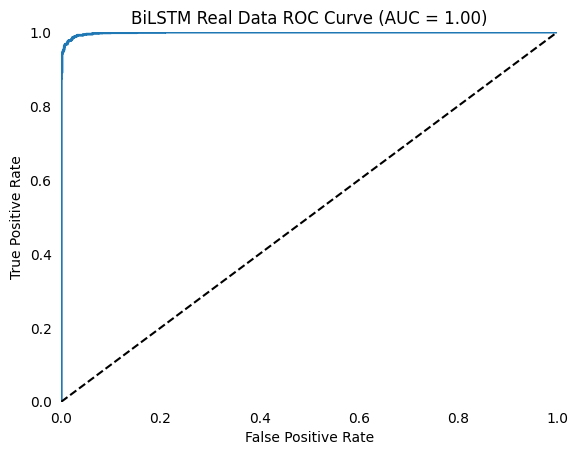

In [86]:
# roc curve for classes
fpr, tpr, thresholds = roc_curve(y_test[:,1], y_pred[:,1])
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # set background color to white
    plt.gca().set_facecolor('white')
    # no black ticks
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    # remove edges
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

# plot ROC curve and save
biLSTM_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
auc_score = auc(fpr, tpr)
plt.title('BiLSTM Real Data ROC Curve (AUC = %0.2f)' % auc_score)
plt.savefig('plots/biLSTM_real_data_roc.png')

[[1966   34]
 [  46 1954]]


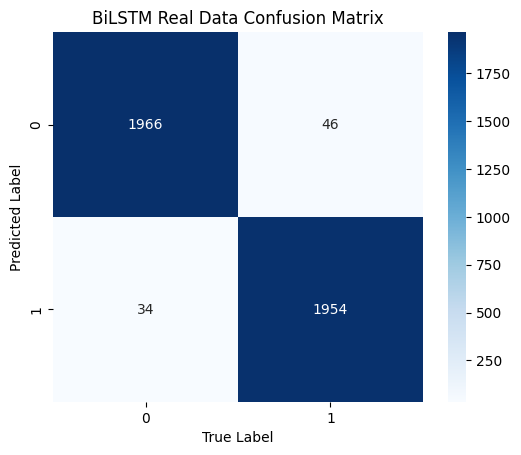

In [71]:
# plot and save the confusion matrix for real data
mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(mat)
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                    xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='Blues')
ax.set_xlabel('True Label')
ax.set_ylabel('Predicted Label')
ax.set_title('BiLSTM Real Data Confusion Matrix')
# save heatmap
ax.figure.savefig('plots/biLSTM_real_data_confusion_matrix.png')

In [28]:
# get classifcation report
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2000
           1       0.98      0.98      0.98      2000

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000



In [33]:
# other metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('F1 Score: ', f1_score(y_test, y_pred))

Accuracy:  0.98
Precision:  0.9828973843058351
Recall:  0.977
F1 Score:  0.9799398194583752


### BiLSTM on Synthetic Data

In [53]:
# load synthetic data
synthetic_data = pd.read_csv('final_data/synthetic_data.csv')

# split synthetic data to train and test evenly
syn_train_data, syn_test_data = train_test_split(synthetic_data, test_size=0.1, random_state=42, stratify=synthetic_data['rating'])

# split data to X and y
X_synthetic = syn_train_data['review']
y_synthetic = syn_train_data['rating']
# convert to one-hot encoding
y_synthetic = to_categorical(y_synthetic)
X_synthetic_test = syn_test_data['review']
y_synthetic_test = syn_test_data['rating']
# convert to one-hot encoding
y_synthetic_test = to_categorical(y_synthetic_test)

# encode text into vectors
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_synthetic)

# vocabulary size
vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(X_synthetic)

# max length of a sequence
max_len = max([len(s) for s in sequences])

# pad sequences
X_synthetic = pad_sequences(sequences, maxlen=max_len)

In [60]:
# tokenize test data
test_sequences = tokenizer.texts_to_sequences(X_synthetic_test)
X_synthetic_test = pad_sequences(test_sequences, maxlen=max_len)

In [54]:
# train biLSTM on synthetic data
# define model
syn_biLSTM_model = Sequential(
    [
        Embedding(vocab_size, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(2, activation='sigmoid')
    ]
)
syn_biLSTM_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
syn_biLSTM_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1473, 128)         1691904   
                                                                 
 bidirectional_9 (Bidirectio  (None, 1473, 128)        98816     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 1,832,066
Trainable params: 1,832,066
Non-trainable params: 0
_________________________________________________________________


In [55]:
# train model
history = syn_biLSTM_model.fit(X_synthetic, y_synthetic, batch_size=64, epochs=100, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

# save model
syn_biLSTM_model.save('models/syn_biLSTM_model.h5')

Epoch 1/100
495/495 [==============================] - 106s 206ms/step - loss: 0.1266 - accuracy: 0.9433 - val_loss: 0.0378 - val_accuracy: 0.9851
Epoch 2/100
495/495 [==============================] - 101s 203ms/step - loss: 0.0845 - accuracy: 0.9735 - val_loss: 0.0395 - val_accuracy: 0.9848
Epoch 3/100
495/495 [==============================] - 101s 204ms/step - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0429 - val_accuracy: 0.9850
Epoch 4/100
495/495 [==============================] - 101s 203ms/step - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.0718 - val_accuracy: 0.9769


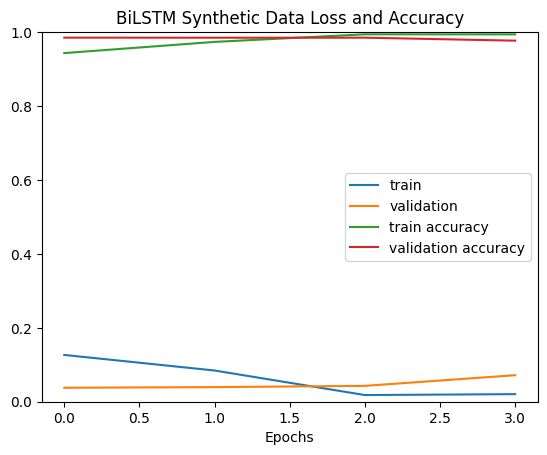

In [56]:
# plot the loss and accuracy
# x-axis: epoch
plt.xlabel('Epochs')
plt.title('BiLSTM Synthetic Data Loss and Accuracy')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'validation', 'train accuracy', 'validation accuracy'], loc='center right')
# ylim 
plt.ylim(0, 1)
# save the plot
plt.savefig('plots/syn_biLSTM_model_accuracy_loss.png')
plt.show()

In [87]:
# load model
syn_biLSTM_model = load_model('models/syn_biLSTM_model.h5')

138/138 [==============================] - 13s 84ms/step


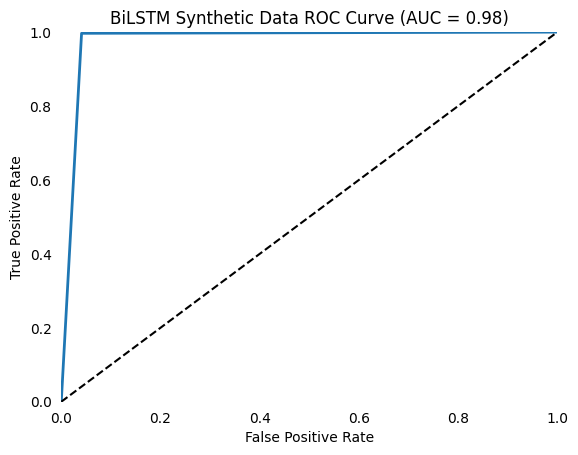

In [88]:
# roc curve for classes
y_pred = syn_biLSTM_model.predict(X_synthetic_test)
fpr, tpr, thresholds = roc_curve(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1))

# plot ROC curve and save
syn_biLSTM_real_roc = plot_roc_curve(fpr, tpr)

# add AUC score
syn_auc_score = auc(fpr, tpr)
plt.title('BiLSTM Synthetic Data ROC Curve (AUC = %0.2f)' % syn_auc_score)

# save the plot
plt.savefig('plots/syn_biLSTM_synthetic_data_roc.png')

[[2110   90]
 [   7 2193]]


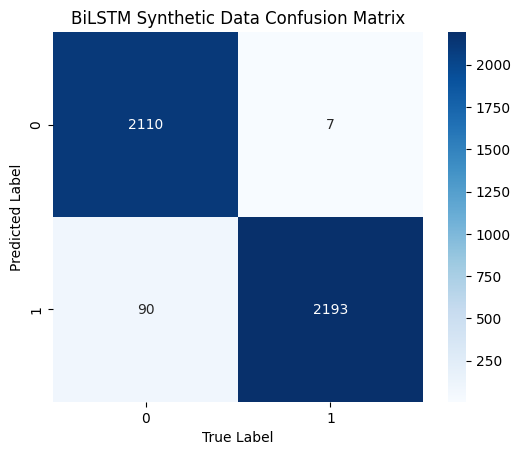

In [66]:
# plot and save the confusion matrix for synthetic data
mat2 = confusion_matrix(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1))
print(mat2)
ax2 = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                    xticklabels=['0', '1'], yticklabels=['0', '1'], cmap='Blues')
ax2.set_xlabel('True Label')
ax2.set_ylabel('Predicted Label')
ax2.set_title('BiLSTM Synthetic Data Confusion Matrix')
# save heatmap
ax2.figure.savefig('plots/biLSTM_synthetic_data_confusion_matrix.png')

In [62]:
# get F1 score, precision, and recall
print(classification_report(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      2200
           1       0.96      1.00      0.98      2200

    accuracy                           0.98      4400
   macro avg       0.98      0.98      0.98      4400
weighted avg       0.98      0.98      0.98      4400



In [75]:
# print other metrics
print('Accuracy: ', accuracy_score(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('F1 Score: ', f1_score(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('Precision: ', precision_score(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1)))
print('Recall: ', recall_score(y_synthetic_test.argmax(axis=1), y_pred.argmax(axis=1)))

Accuracy:  0.9779545454545454
F1 Score:  0.978362703546732
Precision:  0.9605781865965834
Recall:  0.9968181818181818
